In [1]:
import pyvista
from dolfinx import mesh, fem, plot, io, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import ufl
import numpy as np
from dolfinx.plot import vtk_mesh
from dolfinx.io import gmshio
import matplotlib.pyplot as plt
from dolfinx import geometry
import gmsh

In [2]:
pyvista.set_jupyter_backend('trame') 
pyvista.start_xvfb()

In [3]:
gmsh.initialize()

In [4]:
membrane = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [membrane], 1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.03)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.03)
gmsh.model.mesh.generate(gdim)
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000174206s, CPU 0.000279s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.130799s, CPU 0.129318s)
Info    : 4201 nodes 8401 elements


In [5]:
V = fem.functionspace(domain, ("Lagrange", 1))

In [6]:
p = pyvista.Plotter()
topology, cell_types, geom = plot.vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geom)

p.add_mesh(grid, show_edges=True)
p.show()

Widget(value='<iframe src="http://localhost:38939/index.html?ui=P_0x71be74d39d00_0&reconnect=auto" class="pyvi…

In [7]:
x = ufl.SpatialCoordinate(domain)
beta = fem.Constant(domain, default_scalar_type(8))
R0 = fem.Constant(domain, default_scalar_type(0.6))
p = 4 * ufl.exp(-beta**2 * (x[0]**2 + (x[1] - R0)**2))

In [8]:
def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)

boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)
bc = fem.dirichletbc(default_scalar_type(0), boundary_dofs, V)

In [9]:
fem.locate_dofs_geometrical??

Signature:
fem.locate_dofs_geometrical(
    V: 'typing.Union[dolfinx.fem.FunctionSpace, typing.Iterable[dolfinx.fem.FunctionSpace]]',
    marker: 'typing.Callable',
) -> 'np.ndarray'
Source:   
def locate_dofs_geometrical(
    V: typing.Union[dolfinx.fem.FunctionSpace, typing.Iterable[dolfinx.fem.FunctionSpace]],
    marker: typing.Callable,
) -> np.ndarray:
    """Locate degrees-of-freedom geometrically using a marker function.

    Args:
        V: Function space(s) in which to search for degree-of-freedom
            indices.
        marker: A function that takes an array of points ``x`` with
            shape ``(gdim, num_points)`` and returns an array of
            booleans of length ``num_points``, evaluating to ``True``
            for entities whose degree-of-freedom should be returned.

    Returns:
        An array of degree-of-freedom indices (local to the process) for
        degrees-of-freedom whose coordinate evaluates to True for the
        marker function.

        If

In [10]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = p * v * ufl.dx
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [11]:
topology, cell_types, x = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=25)

plotter = pyvista.Plotter()
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u")
plotter.show()

Widget(value='<iframe src="http://localhost:38939/index.html?ui=P_0x71be6e118ef0_1&reconnect=auto" class="pyvi…

In [12]:
Q = fem.functionspace(domain, ("Lagrange", 5))
expr = fem.Expression(p, Q.element.interpolation_points())
pressure = fem.Function(Q)
pressure.interpolate(expr)

load_plotter = pyvista.Plotter()
p_grid = pyvista.UnstructuredGrid(*vtk_mesh(Q))
p_grid.point_data["p"] = pressure.x.array.real
warped_p = p_grid.warp_by_scalar("p", factor=0.5)
warped_p.set_active_scalars("p")
load_plotter.add_mesh(warped_p, show_edges=False, show_scalar_bar=True)
load_plotter.show()

Widget(value='<iframe src="http://localhost:38939/index.html?ui=P_0x71bddff867e0_2&reconnect=auto" class="pyvi…

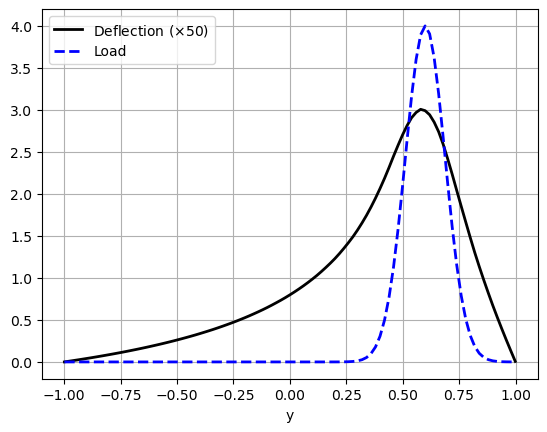

In [13]:
tol = 0.001  # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = np.zeros((3, 101))
points[1] = y
u_values = []
p_values = []
bb_tree = geometry.bb_tree(domain, domain.topology.dim)
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)
p_values = pressure.eval(points_on_proc, cells)
fig = plt.figure()
plt.plot(points_on_proc[:, 1], 50 * u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth=2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")